# Descripción del proyecto

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:

Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.

## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

2026-01-20 21:35:19.337062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df = pd.read_csv(
    '/mnt/c/Users/lans_/Documents/Data Scientist/Sprints Tripleten/Sprint 17/Github/Dataset/labels.csv')
train_datagen = ImageDataGenerator(rescale=1/255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/mnt/c/Users/lans_/Documents/Data Scientist/Sprints Tripleten/Sprint 17/Github/Dataset/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
print(f'Imágenes totales: {len(df)}')
df.head(3)

Imágenes totales: 7591


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


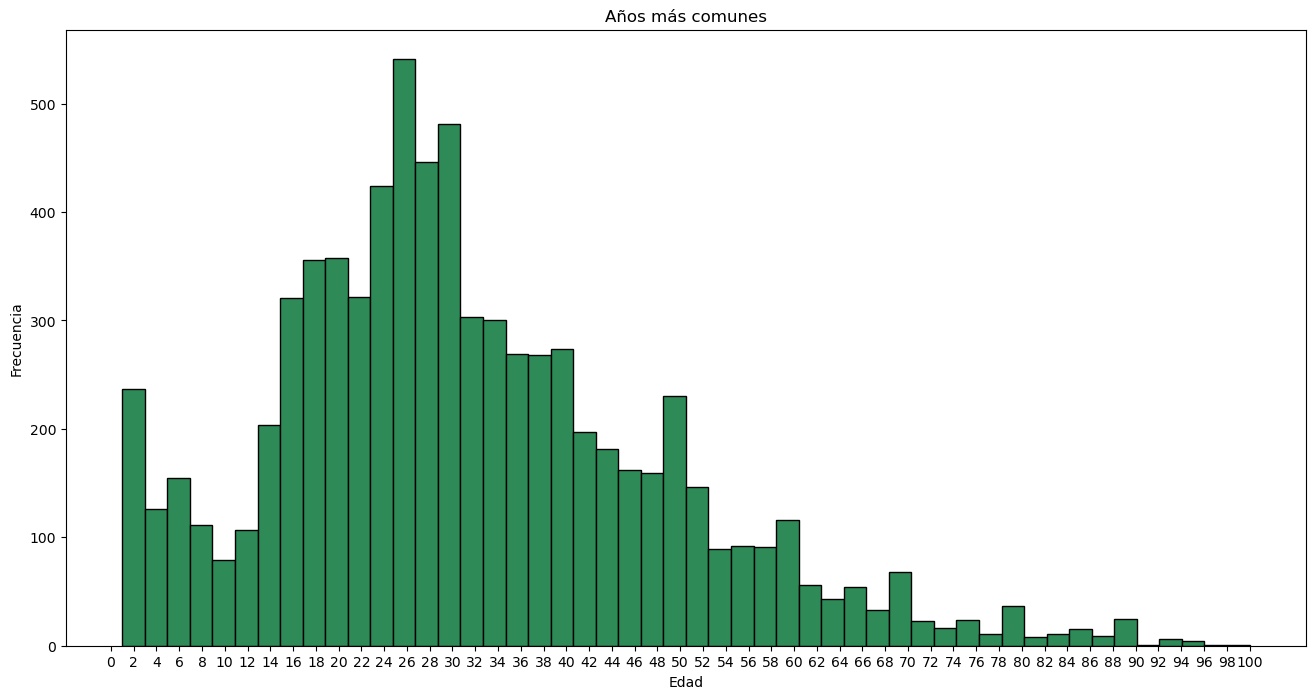

In [4]:
# Histograma de edades
plt.figure(figsize=(16, 8))
plt.hist(df['real_age'], bins=50, edgecolor='black', color='seagreen')
plt.title('Años más comunes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.xticks(range(0, 101, 2))
plt.show()

In [5]:
# Análisis de distribución por grupos de edad
df['age_group'] = pd.cut(df['real_age'],
                         bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 100],
                         labels=['0-10', '11-20', '21-30', '31-40', '41-50',
                                 '51-60', '61-70', '71-80', '81+'])

print(
    f'Edades más comunes (top 10):\n{df["real_age"].value_counts().head(10)}')
print(f'\nDistribución por grupos de edad:\n{df["age_group"].value_counts()}')

Edades más comunes (top 10):
real_age
30    317
25    315
27    229
26    226
28    217
23    213
24    211
16    193
18    193
19    180
Name: count, dtype: int64

Distribución por grupos de edad:
age_group
21-30    2214
31-40    1414
11-20    1346
41-50     929
0-10      708
51-60     534
61-70     254
71-80     111
81+        81
Name: count, dtype: int64


In [6]:
# Análisis descriptivo
print(f'Estadísticas descriptivas:\n{df["real_age"].describe()}')

Estadísticas descriptivas:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


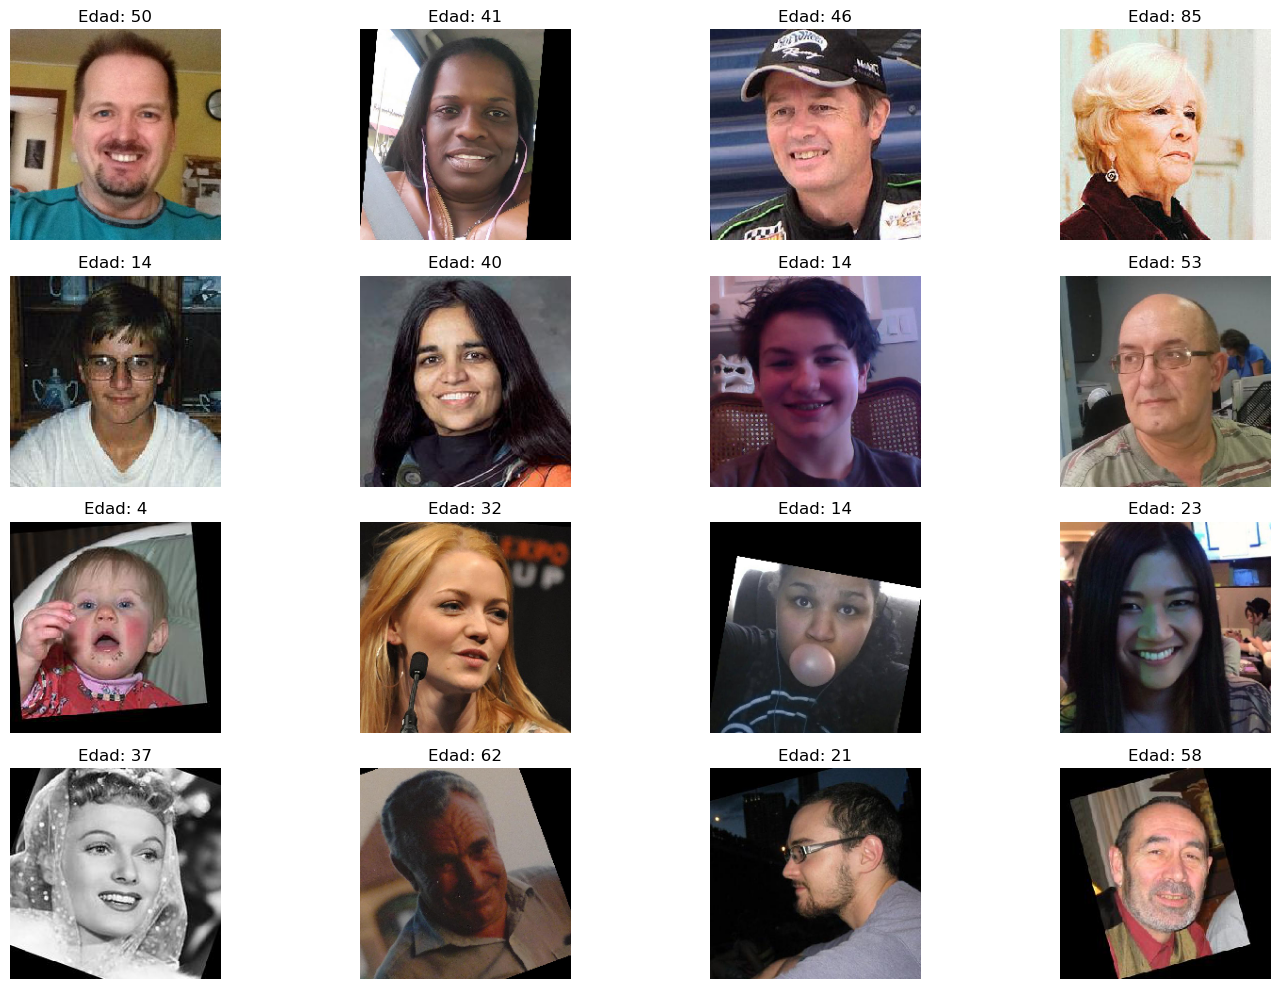

In [7]:
# Obtenemos un lote de imágenes y edades
images, ages = next(train_gen_flow)

plt.figure(figsize=(15, 10))
num_images = 16

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f'Edad: {int(ages[i])}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Conclusiones

La mayoría de imagenes se centran en un **rango de edad de 11 a 40 años**, dado el objetivo de nuestro proyecto de diferenciar quienes son mayores de edad son datos suficientes para diferenciar quien es mayor o menor de 21 años.  
Las imáegenes por otro lado parecen reflejar una calidad suficiente para nuestro modelo.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [8]:
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
def load_data(path):
    """
    Carga el conjunto de datos desde la ruta.
    """

    labels = pd.read_csv(path + 'labels.csv')

    data_datagen = ImageDataGenerator(rescale=1/255,
                                      validation_split=0.20
                                      )

    data_gen_flow_train = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    data_gen_flow_test = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return data_gen_flow_train, data_gen_flow_test

In [10]:
def create_model(input_shape):
    """
    Define el modelo
    """

    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, epochs=20, batch_size=None):
    """
    Entrena el modelo dados los parámetros
    """

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2)

    return model

In [ ]:
input_shape = (224, 224, 3)

train, test = load_data(
    '/mnt/c/Users/lans_/Documents/Data Scientist/Sprints Tripleten/Sprint 17/Github/Dataset/')
model = create_model(input_shape)
model = train_model(model, train, test)

Found 6073 validated image filenames.
Found 1518 validated image filenames.


I0000 00:00:1766105873.621530    6944 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9513 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:2b:00.0, compute capability: 8.9


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/home/lans_92/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-12-18 18:58:14.877002: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a7e60001640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-18 18:58:14.877044: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-12-18 18:58:15.500105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-18 18:58:18.729846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1766105911.569894    7896 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


380/380 - 151s - 397ms/step - loss: 203.7343 - mae: 10.8285 - val_loss: 387.6027 - val_mae: 14.6774
Epoch 2/20
380/380 - 61s - 160ms/step - loss: 130.3666 - mae: 8.7728 - val_loss: 236.6919 - val_mae: 11.4902
Epoch 3/20
380/380 - 60s - 158ms/step - loss: 97.1087 - mae: 7.5039 - val_loss: 120.2889 - val_mae: 8.3487
Epoch 4/20
380/380 - 60s - 157ms/step - loss: 71.0157 - mae: 6.4646 - val_loss: 98.0371 - val_mae: 7.4569
Epoch 5/20
380/380 - 60s - 158ms/step - loss: 48.9184 - mae: 5.4515 - val_loss: 96.6853 - val_mae: 7.5643
Epoch 6/20
380/380 - 60s - 157ms/step - loss: 40.1749 - mae: 4.8977 - val_loss: 99.7097 - val_mae: 7.8174
Epoch 7/20
380/380 - 59s - 156ms/step - loss: 27.2559 - mae: 4.0610 - val_loss: 118.1664 - val_mae: 8.5642
Epoch 8/20
380/380 - 59s - 157ms/step - loss: 25.9594 - mae: 3.9247 - val_loss: 100.9517 - val_mae: 7.8289
Epoch 9/20
380/380 - 60s - 157ms/step - loss: 22.4112 - mae: 3.6617 - val_loss: 91.4856 - val_mae: 7.2289
Epoch 10/20
380/380 - 60s - 158ms/step - loss:

### Resultado

**Epoch 1/20**  
380/380 - 151s - 397ms/step - loss: 203.7343 - mae: 10.8285 - val_loss: 387.6027 - val_mae: 14.6774  
**Epoch 2/20**  
380/380 - 61s - 160ms/step - loss: 130.3666 - mae: 8.7728 - val_loss: 236.6919 - val_mae: 11.4902  
**Epoch 3/20**  
380/380 - 60s - 158ms/step - loss: 97.1087 - mae: 7.5039 - val_loss: 120.2889 - val_mae: 8.3487  
**Epoch 4/20**  
380/380 - 60s - 157ms/step - loss: 71.0157 - mae: 6.4646 - val_loss: 98.0371 - val_mae: 7.4569  
**Epoch 5/20**  
380/380 - 60s - 158ms/step - loss: 48.9184 - mae: 5.4515 - val_loss: 96.6853 - val_mae: 7.5643  
**Epoch 6/20**  
380/380 - 60s - 157ms/step - loss: 40.1749 - mae: 4.8977 - val_loss: 99.7097 - val_mae: 7.8174  
**Epoch 7/20**  
380/380 - 59s - 156ms/step - loss: 27.2559 - mae: 4.0610 - val_loss: 118.1664 - val_mae: 8.5642  
**Epoch 8/20**  
380/380 - 59s - 157ms/step - loss: 25.9594 - mae: 3.9247 - val_loss: 100.9517 - val_mae: 7.8289  
**Epoch 9/20**  
380/380 - 60s - 157ms/step - loss: 22.4112 - mae: 3.6617 - val_loss: 91.4856 - val_mae: 7.2289  
**Epoch 10/20**  
**380/380 - 60s - 158ms/step - loss: 21.2586 - mae: 3.5745 - val_loss: 88.8333 - val_mae: 7.1601**  
**Epoch 11/20**  
380/380 - 60s - 159ms/step - loss: 19.0489 - mae: 3.3987 - val_loss: 108.2116 - val_mae: 8.1795    
**Epoch 12/20**  
380/380 - 59s - 156ms/step - loss: 17.7664 - mae: 3.2475 - val_loss: 96.0480 - val_mae: 7.5337  
**Epoch 13/20**  
380/380 - 60s - 159ms/step - loss: 15.9721 - mae: 3.0821 - val_loss: 108.9296 - val_mae: 7.9555  
**Epoch 14/20**  
380/380 - 61s - 160ms/step - loss: 14.7348 - mae: 2.9554 - val_loss: 91.4448 - val_mae: 7.2649  
**Epoch 15/20**  
380/380 - 61s - 161ms/step - loss: 15.3637 - mae: 3.0135 - val_loss: 91.1054 - val_mae: 7.2187  
**Epoch 16/20**  
380/380 - 62s - 163ms/step - loss: 14.9100 - mae: 2.9703 - val_loss: 97.1677 - val_mae: 7.3662  
**Epoch 17/20**  
380/380 - 61s - 162ms/step - loss: 14.4844 - mae: 2.9319 - val_loss: 169.6607 - val_mae: 10.3340  
**Epoch 18/20**  
380/380 - 62s - 162ms/step - loss: 16.2289 - mae: 3.1064 - val_loss: 99.0412 - val_mae: 7.5228  
**Epoch 19/20**  
380/380 - 61s - 162ms/step - loss: 14.4187 - mae: 2.9168 - val_loss: 91.3355 - val_mae: 7.2498  
**Epoch 20/20**  
380/380 - 61s - 161ms/step - loss: 12.1693 - mae: 2.6784 - val_loss: 84.7367 - val_mae: 6.8685  

## Conclusiones

La mejor época obetnida con nuestra red neuronal 'RedNet50' es la número 10:  
**380/380 - 60s - 158ms/step - loss: 21.2586 - mae: 3.5745 - val_loss: 88.8333 - val_mae: 7.1601**.  

A pesar de ser la mejor tiene un error promedio (val_mae) de 7.16 años, lo que puede significar predecirle 25 años a una persona de 18 y vender alcohol ó predcir a alguien con 24 como 17 y negarle la venta, algunas maneras de solucionarlo sería:

1- Investigar en que rango de edades es donde más se equivoca para saber si es crítico,  
2- Por el objetivo de este proyecto, tratarlo con un modelo de clasificaión, tiene más de 20 años? si (1) o no (0).

In [9]:
# Versiones de librerías
import sys
print("Versiones de las librerías:")
print(f"python=={sys.version}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"tensorflow=={tf.__version__}")

Versiones de las librerías:
python==3.9.25 (main, Nov  3 2025, 22:33:05) 
[GCC 11.2.0]
pandas==2.3.3
numpy==2.0.1
tensorflow==2.20.0
